<a href="https://colab.research.google.com/github/Angelicogfa/analise_fraude/blob/master/04-modelagem_preditiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelagem Preditiva com Modelos Baseados em Contagem

Esse notebook tem como objetivo analisar os dados transacionais agrupados, em janelas de 15 minutos, e avaliar as caracteristicas que podem influênciar na quantidade de contagem de fraudes.

## 1. Importação de bibliotecas e Dados

In [1]:
%pip install statstests

In [2]:
# Bibliotecas para Análise
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
from warnings import filterwarnings
from matplotlib import pyplot as plt

# Bibliotecas para Modelagem
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statstests.tests import overdisp
from statstests.process import stepwise
from statsmodels.iolib.summary2 import summary_col
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP,ZeroInflatedPoisson

filterwarnings('ignore')

In [6]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/transactions_features.parquet','/content/datasets/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
df = pd.read_parquet('/content/datasets/transactions_features.parquet')

## 2. Análise e Modelagem Preditiva com Modelos de Contagem

In [8]:
df.head()

,date_window,frauds,mean_amount,std_amount,mean_current_age,std_current_age,mean_per_capita_income,mean_total_debt,mean_credit_score,std_credit_score,...,category_retail_general_department,category_health_medical,category_sports_recreation,category_retail_clothing_accessories,category_travel_hospitality,category_financial_insurance,category_construction_contractors,category_retail_home_garden,category_manufacturing_industrial,category_personal_services
0,2010-01-01 00:00:00,0,39.623106,46.696554,54.628788,15.136733,22462.931818,58221.810606,716.227273,66.160064,...,0.07,0.03,0.02,0.02,0.01,0.07,0.0,0.00,0.00,0.0
1,2010-01-01 06:00:00,0,35.349520,59.582605,55.579336,15.037152,24074.888069,56695.811808,716.075031,65.384731,...,0.05,0.04,0.01,0.00,0.00,0.05,0.0,0.01,0.00,0.0
2,2010-01-01 12:00:00,0,53.245731,82.216067,56.356397,16.281097,24248.729765,54322.728460,716.154047,63.952840,...,0.07,0.03,0.01,0.01,0.01,0.05,0.0,0.01,0.01,0.0
3,2010-01-01 18:00:00,1,52.219771,61.812329,55.461538,14.783122,24609.155925,53893.916840,708.172557,68.051829,...,0.02,0.02,0.02,0.01,0.00,0.05,0.0,0.01,0.01,0.0
4,2010-01-02 00:00:00,0,77.233604,122.205838,55.333333,13.645068,22904.180180,57401.495495,715.531532,59.232948,...,0.11,0.08,0.02,0.00,0.00,0.05,0.0,0.05,0.00,0.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14363 entries, 0 to 14362
Data columns (total 33 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   date_window                              14363 non-null  datetime64[ns]
 1   frauds                                   14363 non-null  int32         
 2   mean_amount                              14363 non-null  float64       
 3   std_amount                               14360 non-null  float64       
 4   mean_current_age                         14363 non-null  float64       
 5   std_current_age                          14360 non-null  float64       
 6   mean_per_capita_income                   14363 non-null  float64       
 7   mean_total_debt                          14363 non-null  float64       
 8   mean_credit_score                        14363 non-null  float64       
 9   std_credit_score                       

In [12]:
df.describe()

,date_window,frauds,mean_amount,std_amount,mean_current_age,std_current_age,mean_per_capita_income,mean_total_debt,mean_credit_score,std_credit_score,...,category_retail_general_department,category_health_medical,category_sports_recreation,category_retail_clothing_accessories,category_travel_hospitality,category_financial_insurance,category_construction_contractors,category_retail_home_garden,category_manufacturing_industrial,category_personal_services
count,14363,14363.000000,14363.000000,14360.000000,14363.000000,14360.000000,14363.000000,14363.000000,14363.000000,14360.000000,...,14363.000000,14363.000000,14363.000000,14363.000000,14363.000000,14363.000000,14363.000000,14363.000000,14363.000000,14363.000000
mean,2014-12-01 10:40:50.797187328,0.899951,54.350448,74.629319,53.932097,15.585515,23786.155087,57834.713434,714.458627,64.979193,...,0.108564,0.067620,0.004175,0.008541,0.003230,0.049280,0.000143,0.028064,0.010285,0.008723
min,2010-01-01 00:00:00,0.000000,30.616345,0.000000,26.000000,0.000000,9710.000000,686.000000,682.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2012-06-16 21:00:00,0.000000,48.517967,61.940716,53.288771,15.123752,23445.836807,56034.538739,711.920714,63.397313,...,0.090000,0.060000,0.000000,0.010000,0.000000,0.040000,0.000000,0.020000,0.000000,0.000000
50%,2014-12-01 12:00:00,0.000000,54.594355,71.107807,53.992647,15.583383,23873.475331,57806.542056,714.264966,65.433924,...,0.110000,0.070000,0.000000,0.010000,0.000000,0.050000,0.000000,0.030000,0.010000,0.010000
75%,2017-05-17 03:00:00,0.000000,59.877211,82.574142,54.613478,16.098254,24229.841684,59543.420902,716.654522,67.191783,...,0.130000,0.080000,0.010000,0.010000,0.010000,0.060000,0.000000,0.030000,0.010000,0.010000
max,2019-10-31 18:00:00,35.000000,1153.310000,566.435937,68.666667,18.066711,37597.000000,102569.000000,788.000000,77.116653,...,0.250000,0.150000,0.050000,0.050000,1.000000,0.110000,0.220000,0.500000,1.000000,0.040000
std,NaN,2.296641,16.185298,20.268526,1.101963,0.724668,697.953601,2857.429211,4.069693,3.524561,...,0.026591,0.016791,0.005953,0.005940,0.010303,0.012568,0.002150,0.011811,0.014447,0.006991


In [13]:
pd.concat([df['frauds'].value_counts(normalize=True), df['frauds'].value_counts()], axis=1)

,proportion,count
frauds,,
0,0.766274,11006
1,0.066769,959
2,0.045186,649
3,0.027571,396
4,0.021374,307
5,0.017754,255
6,0.012602,181
7,0.011070,159
8,0.008076,116


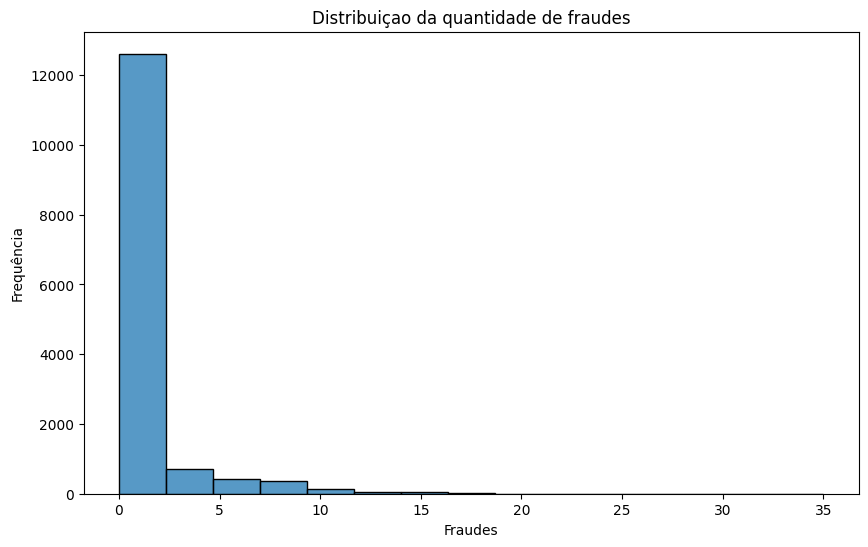

In [18]:
plt.figure(figsize=(10, 6))

plt.title('Distribuiçao da quantidade de fraudes')
sns.histplot(df['frauds'])
plt.xlabel('Fraudes')
plt.ylabel('Frequência')

plt.show()

## Implementação de Modelos

In [19]:
y = df['frauds']
X = df.drop(columns=['date_window'])

### Função de Comparação

In [20]:
def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf

    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1) # 1 grau de liberdade

    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

In [21]:
def compare_models(models_llf: dict):
  df_llf = pd.DataFrame(models_llf)
  fig, ax = plt.subplots(figsize=(15,10))

  c = ['indigo', 'darkgoldenrod']

  ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
  ax.bar_label(ax1, label_type='center', color='white', fontsize=30)
  ax.set_ylabel("Modelo Proposto", fontsize=20)
  ax.set_xlabel("LogLik", fontsize=20)
  ax.tick_params(axis='y', labelsize=20)
  ax.tick_params(axis='x', labelsize=20)
  plt.show()

In [22]:
def overdisp_plot(model, model_type_name):
  pearson_residuals = model.resid_pearson
  fitted_values = model.fittedvalues

  plt.figure(figsize=(10, 6))
  sns.scatterplot(x=fitted_values, y=pearson_residuals, alpha=0.6)
  plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
  plt.xlabel("Valores Preditos (Taxa de Fraudes)")
  plt.ylabel("Resíduos de Pearson Padronizados")
  plt.title(f"Resíduos de Pearson Padronizados vs. Valores Preditos - Modelo: {model_type_name}")
  plt.grid(True, linestyle='--', alpha=0.7)
  plt.show()

In [23]:
def vuong_test(m1, m2):

    from scipy.stats import norm

    if m1.__class__.__name__ == "GLMResultsWrapper":

        glm_family = m1.model.family

        X = pd.DataFrame(data=m1.model.exog, columns=m1.model.exog_names)
        y = pd.Series(m1.model.endog, name=m1.model.endog_names)

        if glm_family.__class__.__name__ == "Poisson":
            m1 = Poisson(endog=y, exog=X).fit()

        if glm_family.__class__.__name__ == "NegativeBinomial":
            m1 = NegativeBinomial(endog=y, exog=X, loglike_method='nb2').fit()

    supported_models = [ZeroInflatedPoisson,ZeroInflatedNegativeBinomialP,Poisson,NegativeBinomial]

    if type(m1.model) not in supported_models:
        raise ValueError(f"Model type not supported for first parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    if type(m2.model) not in supported_models:
        raise ValueError(f"Model type not supported for second parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    # Extração das variáveis dependentes dos modelos
    m1_y = m1.model.endog
    m2_y = m2.model.endog

    m1_n = len(m1_y)
    m2_n = len(m2_y)

    if m1_n == 0 or m2_n == 0:
        raise ValueError("Could not extract dependent variables from models.")

    if m1_n != m2_n:
        raise ValueError("Models appear to have different numbers of observations.\n"
                         f"Model 1 has {m1_n} observations.\n"
                         f"Model 2 has {m2_n} observations.")

    if np.any(m1_y != m2_y):
        raise ValueError("Models appear to have different values on dependent variables.")

    m1_linpred = pd.DataFrame(m1.predict(which="prob"))
    m2_linpred = pd.DataFrame(m2.predict(which="prob"))

    m1_probs = np.repeat(np.nan, m1_n)
    m2_probs = np.repeat(np.nan, m2_n)

    which_col_m1 = [list(m1_linpred.columns).index(x) if x in list(m1_linpred.columns) else None for x in m1_y]
    which_col_m2 = [list(m2_linpred.columns).index(x) if x in list(m2_linpred.columns) else None for x in m2_y]

    for i, v in enumerate(m1_probs):
        m1_probs[i] = m1_linpred.iloc[i, which_col_m1[i]]

    for i, v in enumerate(m2_probs):
        m2_probs[i] = m2_linpred.iloc[i, which_col_m2[i]]

    lm1p = np.log(m1_probs)
    lm2p = np.log(m2_probs)

    m = lm1p - lm2p

    v = np.sum(m) / (np.std(m) * np.sqrt(len(m)))

    pval = 1 - norm.cdf(v) if v > 0 else norm.cdf(v)

    print("Vuong Non-Nested Hypothesis Test-Statistic (Raw):")
    print(f"Vuong z-statistic: {round(v, 3)}")
    print(f"p-value: {pval:.3f}")
    print("")
    print("==================Result======================== \n")
    if pval <= 0.05:
        print("H1: Indicates inflation of zeros at 95% confidence level")
    else:
        print("H0: Indicates no inflation of zeros at 95% confidence level")

### Poisson

Modelo de Regressão de Poisson: Desvendando a Contagem de Eventos


O Modelo de Regressão de Poisson é um tipo de Modelo Linear Generalizado (GLM) amplamente utilizado para modelar dados de contagem, ou seja, variáveis que representam o número de ocorrências de um evento em um determinado intervalo de tempo ou espaço.

A característica fundamental dos dados de contagem é que eles são:

* Não-negativos: Não é possível ter um número negativo de eventos.
* Inteiros: Os eventos ocorrem em unidades discretas (0, 1, 2, ...), não em frações.


#### Formulação Matemática do Modelo de Poisson
Para entender a regressão de Poisson, primeiro precisamos entender a distribuição de Poisson.

Seja Y uma variável aleatória que segue uma distribuição de Poisson. A função de massa de probabilidade (FMP) para Y é dada por:

$
P(Y=k) = \frac{\lambda^k e^{-\lambda}}{k!}
$

Onde:

* $k$ é o número de ocorrências do evento (um inteiro não-negativo: 0,1,2,…).
* $e$ é o número de Euler (aproximadamente 2.71828).
* $k!$ é o fatorial de k.
* $λ$ (lambda) é o parâmetro de taxa da distribuição de Poisson. Ele representa a média e a variância esperada do número de eventos no intervalo especificado.


No contexto da Regressão de Poisson, o objetivo é modelar como o parâmetro de taxa λ é influenciado por um conjunto de variáveis preditoras ($x_1$, $x_2$,…,$x_p$). Como λ deve ser sempre positivo, a regressão de Poisson utiliza uma função de ligação logarítmica para conectar a combinação linear dos preditores ao parâmetro λ.

#### A formulação matemática do modelo de regressão de Poisson é a seguinte:

Assumimos que a variável dependente $Y_i$ para cada observação $i$ segue uma distribuição de Poisson com seu próprio parâmetro de taxa $λ_i$:

$Y_i$∼Poisson($λ_i$)

A função de ligação logarítmica é usada para relacionar o logaritmo da taxa esperada $λ_i$ a uma combinação linear das variáveis preditoras:

$log$($λ_i$)=β0 + $β_1x_i1$ + $β2xi2$ + … + $βpxip$

Onde:

* $λi$ é a taxa esperada (média de contagens) para a observação $i$.
* $β0$ é o intercepto.
* $β1,β2,…,βp$ são os **coeficientes de regressão** para as variáveis preditoras $xi1, xi2,…,xip$, respectivamente.

Para obter a taxa esperada $λi$, podemos exponenciar ambos os lados da equação:

$λ_i=e^{β_0+β1xi1 +β2xi2 +…+βpxip}$

Ou, de forma mais compacta:

$λi=e^{xi^{⊤}β}$

Onde $xi$ é o vetor de variáveis preditoras para a observação i e β é o vetor de coeficientes.


In [24]:
pd.DataFrame({'Média':[df['frauds'].mean()],'Variância':[df['frauds'].var()]})

,Média,Variância
0,0.899951,5.27456


Há indícios de superdispersão.

In [25]:
features_completa_formula = 'frauds ~ ' + ' + '.join(X.drop(columns=['frauds']).columns.to_list())
features_completa_formula

'frauds ~ mean_amount + std_amount + mean_current_age + std_current_age + mean_per_capita_income + mean_total_debt + mean_credit_score + std_credit_score + mean_num_credit_cards + std_num_credit_cards + mean_credit_limit + gender_female + card_brand_amex + card_brand_discover + card_type_debit_prepaid + has_chip_no + category_arts_entertainment_recreation + category_retail_specialty + category_government_utilities + category_food_beverage + category_professional_business_services + category_retail_general_department + category_health_medical + category_sports_recreation + category_retail_clothing_accessories + category_travel_hospitality + category_financial_insurance + category_construction_contractors + category_retail_home_garden + category_manufacturing_industrial + category_personal_services'

In [26]:
modelo_poison_simple = smf.glm(formula='frauds ~ mean_amount', data=X, family=sm.families.Poisson()).fit()
modelo_poison_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14363
Model:                            GLM   Df Residuals:                    14361
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -26152.
Date:                Wed, 28 May 2025   Deviance:                       42461.
Time:                        18:10:47   Pearson chi2:                 1.44e+11
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2051
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.8472      0.051     55.934      0.000       2.747       2.947
mean_amount    -0.0570      0.001    -56.347      0.000      -0.059      -0.055
===============================================================================
"""

Observações do modelo simples

* Intercepto e variavel `transactions` são estatisticamente significantes
* O Log-Likelihood é alto
* Pseudo R-Squ. (CS) indique que apenas a variavel `transaction` explica menos que ~ 11% da variância na contagem de fraudes.



In [27]:
modelo_poison_complete = smf.glm(formula=features_completa_formula, data=X, family=sm.families.Poisson()).fit()
modelo_poison_complete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14360
Model:                            GLM   Df Residuals:                    14328
Model Family:                 Poisson   Df Model:                           31
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23591.
Date:                Wed, 28 May 2025   Deviance:                       37338.
Time:                        18:10:55   Pearson chi2:                 1.03e+12
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4434
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                 -17.2528      2.921     -5.907      0.000     -22.978     -11.528
mean_amount                                -0.0482      0.003    -16.539      0.000      -0.054      -0.043
std_amount                                  0.0102      0.001     16.473      0.000       0.009       0.011
mean_current_age                           -0.0005      0.015     -0.035      0.972      -0.030       0.029
std_current_age                             0.3458      0.021     16.119      0.000       0.304       0.388
mean_per_capita_income                      0.0003   2.54e-05     12.838      0.000       0.000       0.000
mean_total_debt                         -2.073e-05   5.46e-06     -3.798      0.000   -3.14e-05      -1e-05
mean_credit_score                           0.0193      0.004      5.214      0.000       0.012       0.027
std_credit_score                           -0.0028      0.004     -0.633      0.527      -0.011       0.006
mean_num_credit_cards                       0.6929      0.165      4.203      0.000       0.370       1.016
std_num_credit_cards                       -1.0417      0.219     -4.759      0.000      -1.471      -0.613
mean_credit_limit                          -0.0003   2.49e-05    -11.490      0.000      -0.000      -0.000
gender_female                               0.4855      0.455      1.066      0.287      -0.407       1.378
card_brand_amex                            -5.0739      0.867     -5.849      0.000      -6.774      -3.374
card_brand_discover                         2.3526      1.246      1.888      0.059      -0.090       4.795
card_type_debit_prepaid                    -3.7939      0.879     -4.316      0.000      -5.517      -2.071
has_chip_no                                -0.0311      0.705     -0.044      0.965      -1.413       1.351
category_arts_entertainment_recreation    -10.8931      0.822    -13.247      0.000     -12.505      -9.281
category_retail_specialty                  -6.1055      1.022     -5.972      0.000      -8.109      -4.102
category_government_utilities             -20.9340      1.092    -19.162      0.000     -23.075     -18.793
category_food_beverage                     -4.0213      0.407     -9.880      0.000      -4.819      -3.224
category_professional_business_services   -17.7287      1.579    -11.231      0.000     -20.823     -14.635
category_retail_general_department         -1.8922      0.657     -2.880      0.004      -3.180      -0.605
category_health_medical                    -3.3985      0.785     -4.327      0.000      -4.938      -1.859
category_sports_recreation                -19.5536      2.173     -8.998      0.000     -23.813     -15.294
category_retail_clothing_accessories        0.9807      1.8

In [28]:
overdisp(modelo_poison_complete, df)

Estimating model...: 
 GLM
                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.048      
Dependent Variable:     ystar            AIC:                         118526.0408
Date:                   2025-05-28 18:11 BIC:                         118533.6130
No. Observations:       14360            Log-Likelihood:              -59262.    
Df Model:               1                F-statistic:                 732.8      
Df Residuals:           14359            Prob (F-statistic):          1.92e-157  
R-squared (uncentered): 0.049            Scale:                       224.97     
---------------------------------------------------------------------------------------
             Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
---------------------------------------------------------------------------------------
lmbda        2.9424         0.1087       27.0702       0.0000       2.7293    

O teste de superdispersão indica que existe indicios de superdisperção com 95% de confiança

Aplicando o processo stepwise afim de identificar se a melhor seleção de features ajuda a resolver o problema de superdispersão.

In [29]:
modelo_poisson_stepswise = stepwise(modelo_poison_complete, pvalue_limit=0.05)
modelo_poisson_stepswise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('mean_amount') + Q('std_amount') + Q('mean_current_age') + Q('std_current_age') + Q('mean_per_capita_income') + Q('mean_total_debt') + Q('mean_credit_score') + Q('std_credit_score') + Q('mean_num_credit_cards') + Q('std_num_credit_cards') + Q('mean_credit_limit') + Q('gender_female') + Q('card_brand_amex') + Q('card_brand_discover') + Q('card_type_debit_prepaid') + Q('has_chip_no') + Q('category_arts_entertainment_recreation') + Q('category_retail_specialty') + Q('category_government_utilities') + Q('category_food_beverage') + Q('category_professional_business_services') + Q('category_retail_general_department') + Q('category_health_medical') + Q('category_sports_recreation') + Q('category_retail_clothing_accessories') + Q('category_travel_hospitality') + Q('category_financial_insurance') + Q('category_construction_contractors') + Q('category_retail_home_garden') + Q('category_manufacturing_industrial') + Q('category_personal_ser

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14360
Model:                            GLM   Df Residuals:                    14337
Model Family:                 Poisson   Df Model:                           22
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23597.
Date:                Wed, 28 May 2025   Deviance:                       37351.
Time:                        18:11:11   Pearson chi2:                 9.09e+11
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4429
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                      -18.5358      2.440     -7.597      0.000     -23.318     -13.754
Q('mean_amount')                                -0.0486      0.003    -17.233      0.000      -0.054      -0.043
Q('std_amount')                                  0.0101      0.001     16.588      0.000       0.009       0.011
Q('std_current_age')                             0.3511      0.021     16.778      0.000       0.310       0.392
Q('mean_per_capita_income')                      0.0003   2.44e-05     13.417      0.000       0.000       0.000
Q('mean_total_debt')                         -2.071e-05   5.09e-06     -4.065      0.000   -3.07e-05   -1.07e-05
Q('mean_credit_score')                           0.0208      0.003      6.196      0.000       0.014       0.027
Q('mean_num_credit_cards')                       0.7015      0.148      4.726      0.000       0.411       0.992
Q('std_num_credit_cards')                       -1.0407      0.217     -4.798      0.000      -1.466      -0.616
Q('mean_credit_limit')                          -0.0003   2.44e-05    -11.775      0.000      -0.000      -0.000
Q('card_brand_amex')                            -5.1752      0.864     -5.989      0.000      -6.869      -3.482
Q('card_type_debit_prepaid')                    -3.9098      0.876     -4.463      0.000      -5.627      -2.193
Q('category_arts_entertainment_recreation')    -10.8549      0.810    -13.399      0.000     -12.443      -9.267
Q('category_retail_specialty')                  -6.0618      1.014     -5.975      0.000      -8.050      -4.074
Q('category_government_utilities')             -20.6787      1.073    -19.269      0.000     -22.782     -18.575
Q('category_food_beverage')                     -3.6834      0.367    -10.043      0.000      -4.402      -2.965
Q('category_professional_business_services')   -17.5370      1.572    -11.157      0.000     -20.618     -14.456
Q('category_retail_general_department')         -1.7829      0.650     -2.741      0.006      -3.058      -0.508
Q('category_health_medical')                    -3.2647      0.780     -4.187      0.000      -4.793      -1.736
Q('category_sports_recreation')                -19.5564      2.164     -9.037      0.000     -23.798     -15.315
Q('category_travel_hospitality')               -30.3871      3.077     -9.876      0.000     -36.418     -24.357
Q('category_manufacturing_industrial')          -5.4587      1.453     -3.758      0.000      -8.306      -2.612
Q('category_personal_services')                 13.3083      1.719      7.741      0.000       9.939      16.678
================================================================================================================
"""

Aplicando a analise de superdispersão e a "plotagem" do gráfico de valores preditos X os residuos ajustados para comparar como o modelo se comporta em relação a superdispersão.

In [30]:
overdisp(modelo_poisson_stepswise, df)

Estimating model...: 
 GLM
                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.049      
Dependent Variable:     ystar            AIC:                         118434.7547
Date:                   2025-05-28 18:14 BIC:                         118442.3269
No. Observations:       14360            Log-Likelihood:              -59216.    
Df Model:               1                F-statistic:                 739.3      
Df Residuals:           14359            Prob (F-statistic):          8.70e-159  
R-squared (uncentered): 0.049            Scale:                       223.54     
---------------------------------------------------------------------------------------
             Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
---------------------------------------------------------------------------------------
lmbda        2.9482         0.1084       27.1899       0.0000       2.7357    

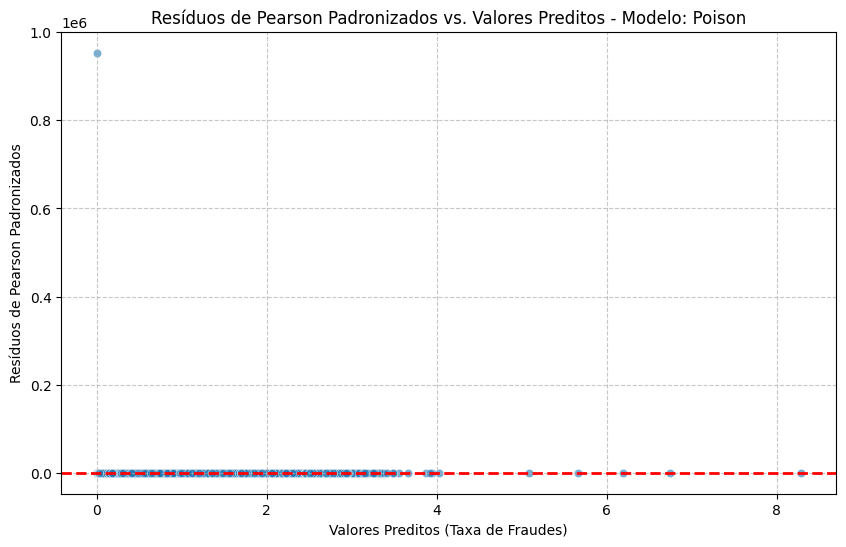

In [31]:
overdisp_plot(modelo_poisson_stepswise, 'Poison')

TODO: Rever

O gráfico evidencia uma caracteristica marcante no problema de superdispersão que é o padrão de "cone" extremamente acentuado, que se abre drasticamente quando os valores preditos se aproximam de zero. Caso o modelo fosse bem ajustado, eperariamos que os resudios estivessem distribuidos em torno de zero, sem padrões visiveis e com uma variancia mais ou menos constante.

In [32]:
summary_col([modelo_poison_simple, modelo_poison_complete, modelo_poisson_stepswise],
            model_names=["Poisson Simples", "Poisson Completo", "Poisson StepWise"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
        })

,Poisson Simples,Poisson Completo,Poisson StepWise
Intercept,2.8472***,-17.2528***,-18.5358***
,(0.0509),(2.9208),(2.4399)
mean_amount,-0.0570***,-0.0482***,
,(0.0010),(0.0029),
std_amount,,0.0102***,
,,(0.0006),
mean_current_age,,-0.0005,
,,(0.0152),
std_current_age,,0.3458***,
,,(0.0215),


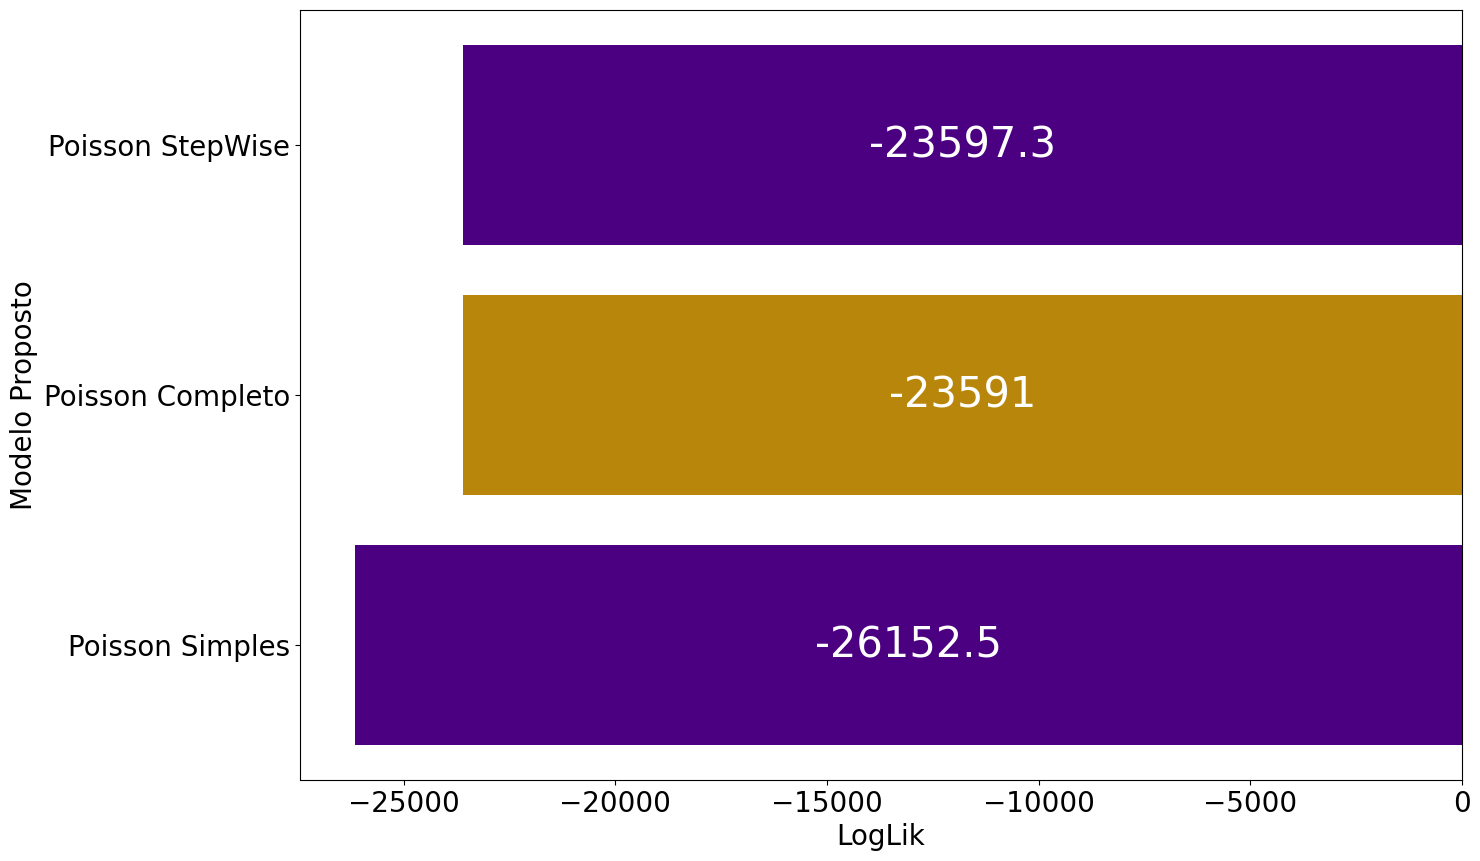

In [33]:
compare_models({
    'modelo':['Poisson Simples', 'Poisson Completo', 'Poisson StepWise'],
    'loglik':[modelo_poison_simple.llf, modelo_poison_complete.llf, modelo_poisson_stepswise.llf]
})

### Binomial Negative (Poisson-Gama)

In [34]:
modelo_binomialneg_simples = smf.glm(formula='frauds ~ mean_amount', data=X, family=sm.families.NegativeBinomial()).fit()
modelo_binomialneg_simples.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14363
Model:                            GLM   Df Residuals:                    14361
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17923.
Date:                Wed, 28 May 2025   Deviance:                       20968.
Time:                        18:14:56   Pearson chi2:                 4.15e+12
No. Iterations:                    10   Pseudo R-squ. (CS):             0.1244
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.2332      0.076     42.695      0.000       3.085       3.382
mean_amount    -0.0645      0.001    -44.341      0.000      -0.067      -0.062
===============================================================================
"""

In [35]:
modelo_binomialneg_completo = smf.glm(formula=features_completa_formula, data=X, family=sm.families.NegativeBinomial()).fit()
modelo_binomialneg_completo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14360
Model:                            GLM   Df Residuals:                    14328
Model Family:        NegativeBinomial   Df Model:                           31
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16493.
Date:                Wed, 28 May 2025   Deviance:                       18109.
Time:                        18:15:03   Pearson chi2:                 5.35e+12
No. Iterations:                     9   Pseudo R-squ. (CS):             0.2823
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                 -17.1038      4.072     -4.201      0.000     -25.084      -9.124
mean_amount                                -0.0549      0.004    -13.430      0.000      -0.063      -0.047
std_amount                                  0.0113      0.001     11.462      0.000       0.009       0.013
mean_current_age                            0.0082      0.021      0.383      0.702      -0.034       0.050
std_current_age                             0.3191      0.030     10.643      0.000       0.260       0.378
mean_per_capita_income                      0.0004   3.56e-05     10.402      0.000       0.000       0.000
mean_total_debt                         -2.409e-05   7.58e-06     -3.176      0.001    -3.9e-05   -9.22e-06
mean_credit_score                           0.0181      0.005      3.501      0.000       0.008       0.028
std_credit_score                            0.0011      0.006      0.178      0.859      -0.011       0.013
mean_num_credit_cards                       0.6686      0.229      2.916      0.004       0.219       1.118
std_num_credit_cards                       -1.1838      0.303     -3.907      0.000      -1.778      -0.590
mean_credit_limit                          -0.0003    3.5e-05     -7.994      0.000      -0.000      -0.000
gender_female                               0.2311      0.630      0.367      0.714      -1.003       1.465
card_brand_amex                            -3.6031      1.205     -2.990      0.003      -5.965      -1.242
card_brand_discover                         1.6389      1.750      0.936      0.349      -1.791       5.069
card_type_debit_prepaid                    -2.7600      1.236     -2.233      0.026      -5.182      -0.338
has_chip_no                                 0.0447      0.981      0.046      0.964      -1.878       1.967
category_arts_entertainment_recreation    -10.4169      1.032    -10.095      0.000     -12.439      -8.395
category_retail_specialty                  -7.5085      1.447     -5.188      0.000     -10.345      -4.672
category_government_utilities             -18.8212      1.467    -12.831      0.000     -21.696     -15.946
category_food_beverage                     -4.2686      0.569     -7.504      0.000      -5.383      -3.154
category_professional_business_services   -20.0395      2.228     -8.994      0.000     -24.407     -15.672
category_retail_general_department         -2.3780      0.915     -2.598      0.009      -4.172      -0.584
category_health_medical                    -3.9119      1.119     -3.496      0.000      -6.105      -1.719
category_sports_recreation                -17.2896      2.974     -5.813      0.000     -23.119     -11.460
category_retail_clothing_accessories        1.9365      2.6

In [36]:
modelo_binomialneg_stepwise = stepwise(modelo_binomialneg_completo, pvalue_limit=0.05)
modelo_binomialneg_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('mean_amount') + Q('std_amount') + Q('mean_current_age') + Q('std_current_age') + Q('mean_per_capita_income') + Q('mean_total_debt') + Q('mean_credit_score') + Q('std_credit_score') + Q('mean_num_credit_cards') + Q('std_num_credit_cards') + Q('mean_credit_limit') + Q('gender_female') + Q('card_brand_amex') + Q('card_brand_discover') + Q('card_type_debit_prepaid') + Q('has_chip_no') + Q('category_arts_entertainment_recreation') + Q('category_retail_specialty') + Q('category_government_utilities') + Q('category_food_beverage') + Q('category_professional_business_services') + Q('category_retail_general_department') + Q('category_health_medical') + Q('category_sports_recreation') + Q('category_retail_clothing_accessories') + Q('category_travel_hospitality') + Q('category_financial_insurance') + Q('category_construction_contractors') + Q('category_retail_home_garden') + Q('category_manufacturing_industrial') + Q('category_personal_ser

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14360
Model:                            GLM   Df Residuals:                    14337
Model Family:        NegativeBinomial   Df Model:                           22
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16495.
Date:                Wed, 28 May 2025   Deviance:                       18112.
Time:                        18:15:09   Pearson chi2:                 3.81e+12
No. Iterations:                     9   Pseudo R-squ. (CS):             0.2822
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                      -15.8785      3.399     -4.671      0.000     -22.541      -9.216
Q('mean_amount')                                -0.0551      0.004    -13.998      0.000      -0.063      -0.047
Q('std_amount')                                  0.0113      0.001     11.570      0.000       0.009       0.013
Q('std_current_age')                             0.3220      0.029     11.062      0.000       0.265       0.379
Q('mean_per_capita_income')                      0.0004    3.4e-05     11.105      0.000       0.000       0.000
Q('mean_total_debt')                         -2.501e-05   7.09e-06     -3.530      0.000   -3.89e-05   -1.11e-05
Q('mean_credit_score')                           0.0171      0.005      3.653      0.000       0.008       0.026
Q('mean_num_credit_cards')                       0.7061      0.207      3.413      0.001       0.301       1.112
Q('std_num_credit_cards')                       -1.1761      0.300     -3.922      0.000      -1.764      -0.588
Q('mean_credit_limit')                          -0.0003   3.43e-05     -8.342      0.000      -0.000      -0.000
Q('card_brand_amex')                            -3.6356      1.199     -3.032      0.002      -5.985      -1.286
Q('card_type_debit_prepaid')                    -2.9286      1.230     -2.382      0.017      -5.338      -0.519
Q('category_arts_entertainment_recreation')    -10.3677      1.016    -10.208      0.000     -12.358      -8.377
Q('category_retail_specialty')                  -7.6329      1.433     -5.326      0.000     -10.442      -4.824
Q('category_government_utilities')             -18.9203      1.437    -13.165      0.000     -21.737     -16.104
Q('category_food_beverage')                     -4.2201      0.511     -8.257      0.000      -5.222      -3.218
Q('category_professional_business_services')   -20.1032      2.217     -9.068      0.000     -24.448     -15.758
Q('category_retail_general_department')         -2.4642      0.906     -2.720      0.007      -4.240      -0.689
Q('category_health_medical')                    -3.9647      1.110     -3.572      0.000      -6.140      -1.789
Q('category_sports_recreation')                -16.9982      2.960     -5.742      0.000     -22.800     -11.196
Q('category_travel_hospitality')               -24.8852      3.856     -6.454      0.000     -32.442     -17.329
Q('category_manufacturing_industrial')          -6.9838      2.009     -3.476      0.001     -10.922      -3.046
Q('category_personal_services')                 17.6827      2.527      6.998      0.000      12.730      22.635
================================================================================================================
"""

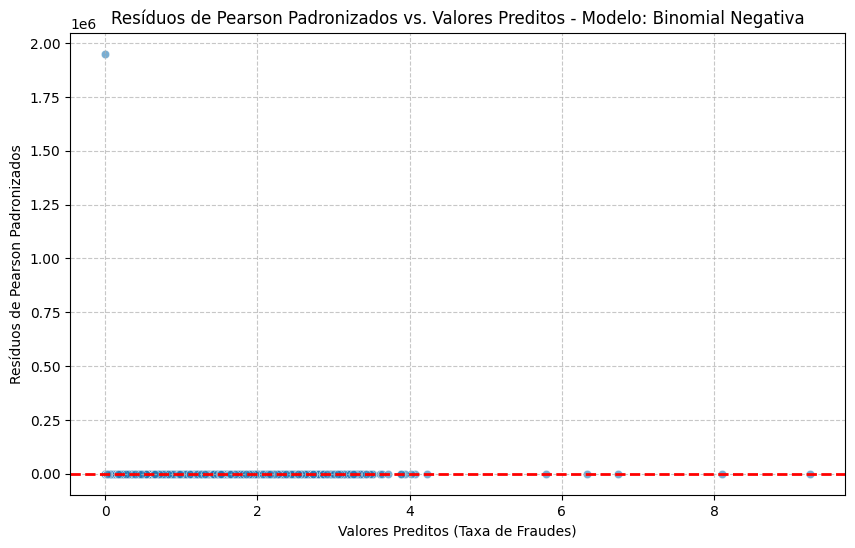

In [37]:
overdisp_plot(modelo_binomialneg_stepwise, 'Binomial Negativa')

In [38]:
lrtest([modelo_poisson_stepswise, modelo_binomialneg_stepwise])

Likelihood Ratio Test:
-2.(LL0-LLm): 14204.35
p-value: 0.000

==================Result======================== 

H1: Different models, favoring the one with the highest Log-Likelihood


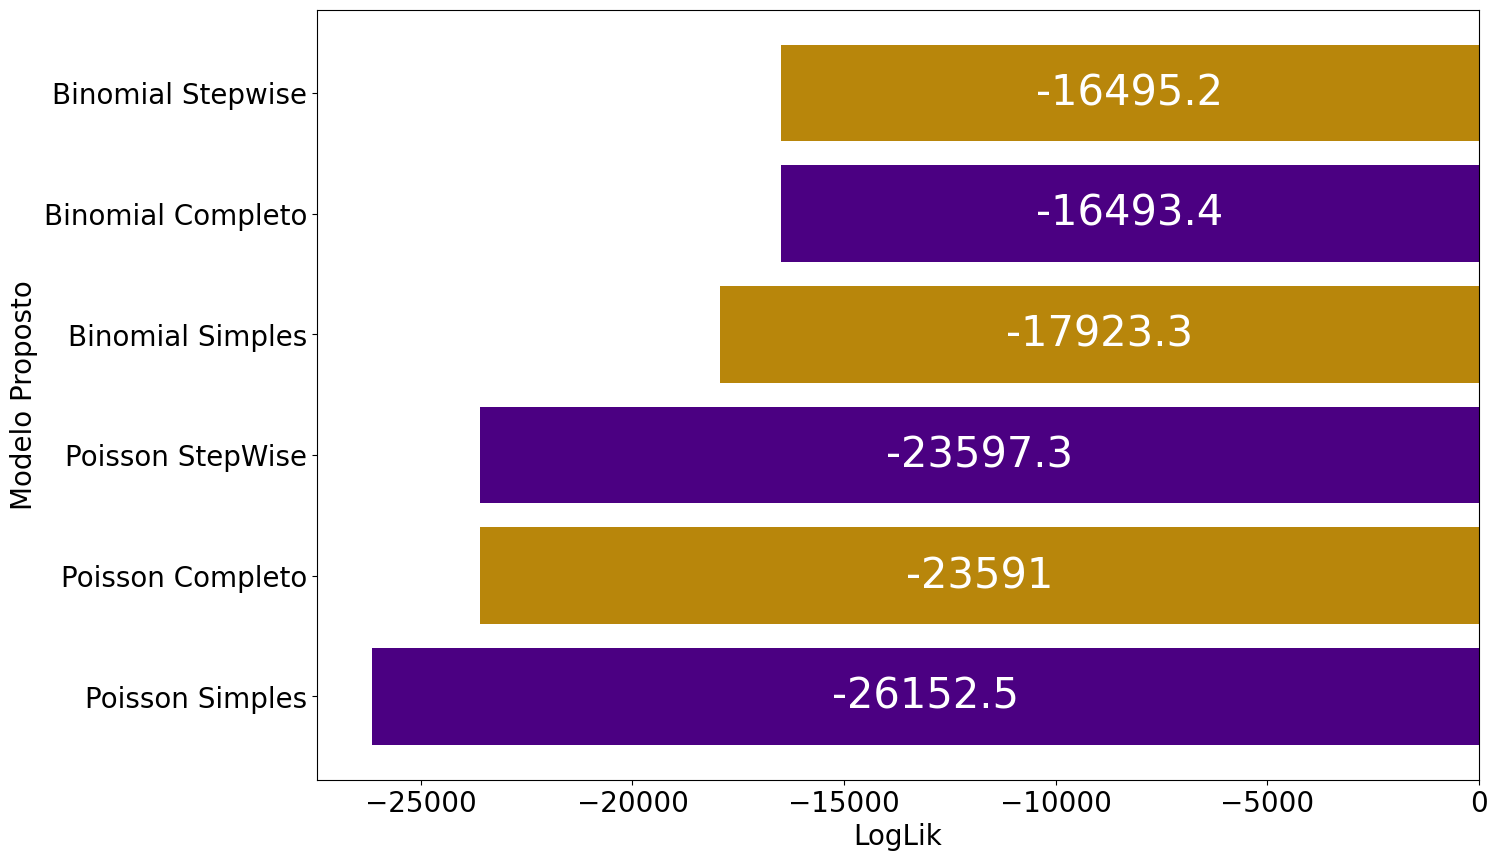

In [39]:
compare_models({
    'modelo':['Poisson Simples', 'Poisson Completo', 'Poisson StepWise', 'Binomial Simples', 'Binomial Completo', 'Binomial Stepwise'],
    'loglik':[modelo_poison_simple.llf, modelo_poison_complete.llf, modelo_poisson_stepswise.llf, modelo_binomialneg_simples.llf, modelo_binomialneg_completo.llf, modelo_binomialneg_stepwise.llf]
})

### Zero Inflated Poison

In [41]:
X1 = X['mean_amount'].copy()
X1 = sm.add_constant(X1)

In [42]:
modelo_zip_simples = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1, inflation='logit').fit()
modelo_zip_simples.summary()

Optimization terminated successfully.
         Current function value: 1.135803
         Iterations: 27
         Function evaluations: 37
         Gradient evaluations: 32


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                14363
Model:             ZeroInflatedPoisson   Df Residuals:                    14361
Method:                            MLE   Df Model:                            1
Date:                 Wed, 28 May 2025   Pseudo R-squ.:                 0.02580
Time:                         18:21:20   Log-Likelihood:                -16314.
converged:                        True   LL-Null:                       -16746.
Covariance Type:             nonrobust   LLR p-value:                6.132e-190
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
inflate_const          -1.5865      0.123    -12.850      0.000      -1.828      -1.345
inflate_mean_amount     0.0516      0.002     21.970      0.000       0.047       0.056
const                   2.2771      0.057     40.216      0.000       2.166       2.388
mean_amount            -0.0191      0.001    -16.789      0.000      -0.021      -0.017
=======================================================================================
"""

In [43]:
vuong_test(modelo_poison_simple, modelo_zip_simples)

Optimization terminated successfully.
         Current function value: 1.820823
         Iterations 6
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -38.885
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


In [44]:
X_log = X.drop(columns=['frauds']).copy()
for column in X_log.columns:
  X_log[column] = np.log(X_log[column] + 1)
X_log.head()

,mean_amount,std_amount,mean_current_age,std_current_age,mean_per_capita_income,mean_total_debt,mean_credit_score,std_credit_score,mean_num_credit_cards,std_num_credit_cards,...,category_retail_general_department,category_health_medical,category_sports_recreation,category_retail_clothing_accessories,category_travel_hospitality,category_financial_insurance,category_construction_contractors,category_retail_home_garden,category_manufacturing_industrial,category_personal_services
0,3.704337,3.864859,4.018701,2.781098,10.019666,10.972032,6.575393,4.207079,1.598775,0.914125,...,0.067659,0.029559,0.019803,0.019803,0.00995,0.067659,0.0,0.00000,0.00000,0.0
1,3.593181,4.104008,4.035644,2.774908,10.088966,10.945473,6.575180,4.195467,1.605247,0.937929,...,0.048790,0.039221,0.009950,0.000000,0.00000,0.048790,0.0,0.00995,0.00000,0.0
2,3.993524,4.421440,4.049284,2.849613,10.096161,10.902716,6.575291,4.173661,1.585391,0.942696,...,0.067659,0.029559,0.009950,0.009950,0.00995,0.048790,0.0,0.00995,0.00995,0.0
3,3.974430,4.140151,4.033560,2.758941,10.110914,10.894791,6.564099,4.234857,1.574747,0.932604,...,0.019803,0.019803,0.019803,0.009950,0.00000,0.048790,0.0,0.00995,0.00995,0.0
4,4.359699,4.813856,4.031286,2.684104,10.039118,10.957843,6.574422,4.098220,1.589419,0.923981,...,0.104360,0.076961,0.019803,0.000000,0.00000,0.048790,0.0,0.04879,0.00000,0.0


In [45]:
exclude_columns = X_log.isna().sum().reset_index().rename(columns={0:'missing'}).query('missing > 0')['index'].to_list()
X_droped = X.drop(columns=exclude_columns)

In [46]:
standard_scaler = StandardScaler()
X_scaler = standard_scaler.fit_transform(X_droped)

X_scaler = pd.DataFrame(X_scaler, columns=X_droped.columns).drop(columns='frauds')
X_scaler.head()

,mean_amount,mean_current_age,mean_per_capita_income,mean_total_debt,mean_credit_score,mean_num_credit_cards,mean_credit_limit,gender_female,card_brand_amex,card_brand_discover,...,category_retail_general_department,category_health_medical,category_sports_recreation,category_retail_clothing_accessories,category_travel_hospitality,category_financial_insurance,category_construction_contractors,category_retail_home_garden,category_manufacturing_industrial,category_personal_services
0,-0.909953,0.632249,-1.895927,0.135475,0.434605,0.978767,0.882949,0.202150,-0.323983,-2.711766,...,-1.450323,-2.240616,2.658513,1.929110,0.657105,1.648677,-0.066378,-2.376155,-0.711926,-1.24776
1,-1.174003,1.494874,0.413699,-0.398589,0.397195,1.323994,-0.618196,0.202150,0.369412,-0.611178,...,-2.202479,-1.645028,0.978535,-1.437778,-0.313483,0.057283,-0.066378,-1.529478,-0.711926,-1.24776
2,-0.068257,2.200059,0.662782,-1.229114,0.416611,0.271885,0.398898,-0.498411,0.369412,-0.611178,...,-1.450323,-2.240616,0.978535,0.245666,0.657105,0.057283,-0.066378,-1.529478,-0.019711,-1.24776
3,-0.131647,1.387973,1.179204,-1.379189,-1.544659,-0.283564,-0.804512,0.552430,-1.017378,1.489409,...,-3.330715,-2.836203,2.658513,0.245666,-0.313483,0.057283,-0.066378,-1.529478,-0.019711,-1.24776
4,1.413873,1.271626,-1.263702,-0.151616,0.263642,0.483619,-1.497841,-2.249813,1.062807,-1.661472,...,0.053991,0.737321,2.658513,-1.437778,-0.313483,0.057283,-0.066378,1.857231,-0.711926,-1.24776


In [50]:
X1 = X_scaler.copy(deep=True)
X1 = sm.add_constant(X1)

In [51]:
modelo_zip_complete = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1, inflation='logit').fit()
modelo_zip_complete.summary()

         Current function value: 1.076419
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                14363
Model:             ZeroInflatedPoisson   Df Residuals:                    14335
Method:                            MLE   Df Model:                           27
Date:                 Wed, 28 May 2025   Pseudo R-squ.:                 0.07674
Time:                         18:22:15   Log-Likelihood:                -15461.
converged:                       False   LL-Null:                       -16746.
Covariance Type:             nonrobust   LLR p-value:                     0.000
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                       1.2215      0.023     52.198      0.000       1.176       1.267
inflate_mean_amount                                 0.2150      0.078      2.774      0.006       0.063       0.367
inflate_mean_current_age                           -0.0151      0.034     -0.448      0.654      -0.081       0.051
inflate_mean_per_capita_income                     -0.1696      0.037     -4.605      0.000      -0.242      -0.097
inflate_mean_total_debt                             0.0966      0.031      3.094      0.002       0.035       0.158
inflate_mean_credit_score                          -0.0252      0.029     -0.874      0.382      -0.082       0.031
inflate_mean_num_credit_cards                      -0.0716      0.031     -2.293      0.022      -0.133      -0.010
inflate_mean_credit_limit                           0.1146      0.034      3.369      0.001       0.048       0.181
inflate_gender_female                              -0.0095      0.026     -0.364      0.716      -0.061       0.042
inflate_card_brand_amex                             0.0045      0.026      0.173      0.863      -0.046       0.055
inflate_card_brand_discover                         0.0203      0.025      0.810      0.418      -0.029       0.070
inflate_card_type_debit_prepaid                     0.0105      0.029      0.363      0.717      -0.046       0.067
inflate_has_chip_no                                 0.0494      0.025      2.007      0.045       0.001       0.098
inflate_category_arts_entertainment_recreation      0.2258      0.036      6.285      0.000       0.155       0.296
inflate_category_retail_specialty                   0.1036      0.032      3.273      0.001       0.042       0.166
inflate_category_government_utilities               0.1802      0.039      4.673      0.000       0.105       0.256
inflate_category_food_beverage                      0.0166      0.046      0.359      0.720      -0.074       0.107
inflate_category_professional_business_services     0.1468      0.029      5.055      0.000       0.090       0.204
inflate_category_retail_general_department          0.0596      0.036      1.672      0.095      -0.010       0.129
inflate_category_health_medical                     0.0152      0.028      0.536      0.592      -0.040       0.071
inflate_category_sports_recreation                  0.0953      0.027      3.566      0.000       0.043       0.148
inflate_category_retail_clothing_accessories       -0.0166      0.023     -0.709      0.478      -0.063       0.029
inflate_category_travel_hospitality                 0.1144      0.057      2.006      0.045       0.003       0.226
inflate_category_financial_insurance               -0.0185      0.027     -0.685      0.494      -0.072       0.034
inflate_category_construction_contractors          -0.0340      0.054     -0.630      0.529      -0.

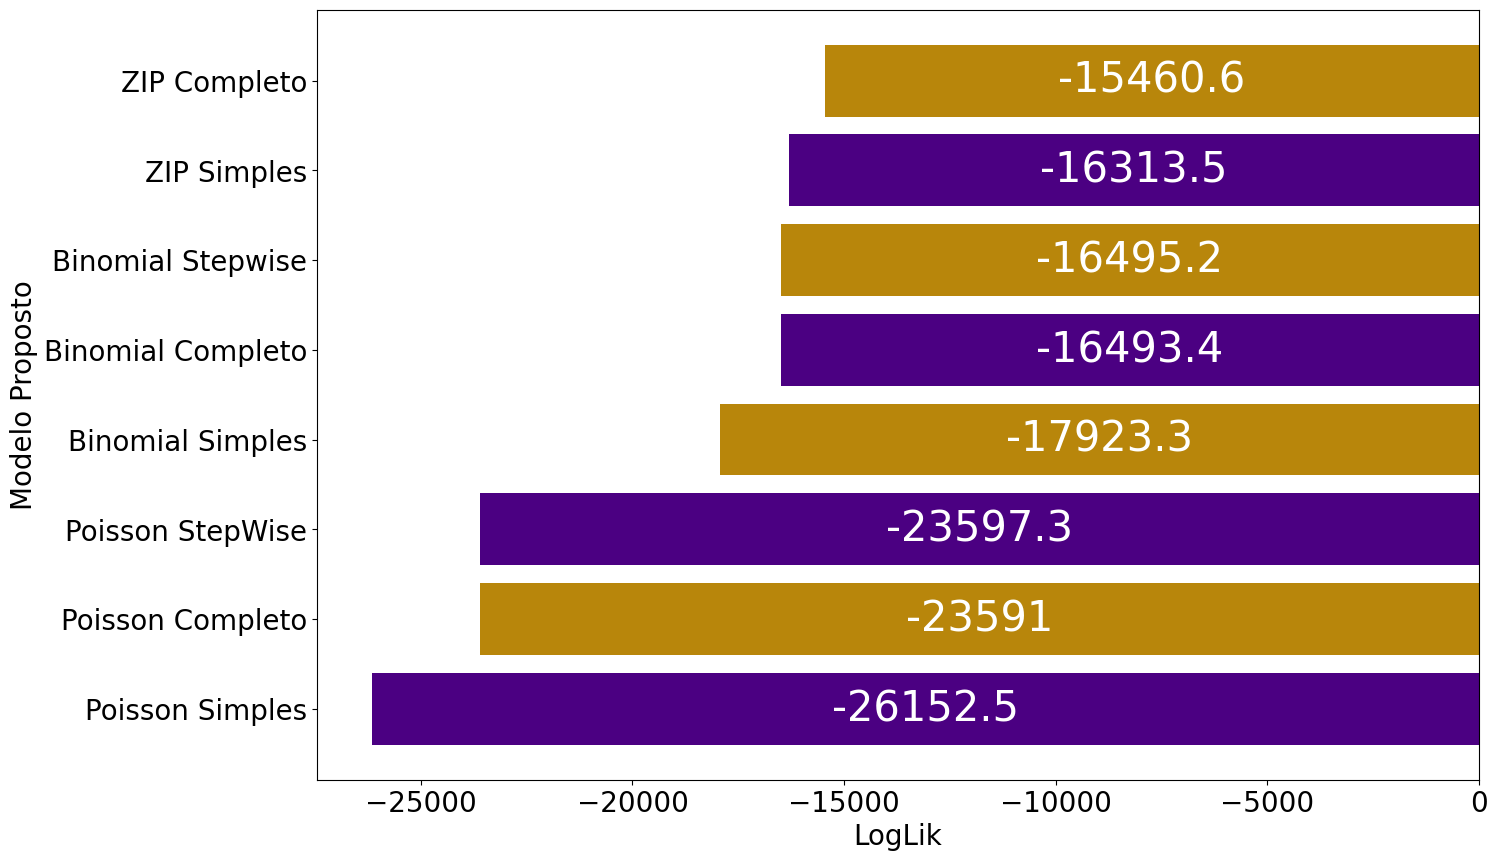

In [52]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf
      ]
})

In [55]:
df_features_zip_complete = modelo_zip_complete.pvalues.where(lambda x: x < 0.05).dropna().reset_index().rename(columns={'index':'Features', 0:'P-Value'})
feature_exog = list(filter(lambda x: x!='const', df_features_zip_complete.query('~Features.str.contains("inflate_")')['Features'].apply(lambda x: str(x).replace('inflate_','')).to_list()))
print('Exogenas')
print(feature_exog)
feature_exog_inflate = list(filter(lambda x: x!='const', df_features_zip_complete.query('Features.str.contains("inflate_")')['Features'].apply(lambda x: str(x).replace('inflate_','')).to_list()))
print('Exogenas Inflado')
print(feature_exog_inflate)

Exogenas
['mean_amount', 'mean_current_age', 'mean_per_capita_income', 'mean_total_debt', 'mean_credit_score', 'mean_credit_limit', 'card_brand_amex', 'has_chip_no', 'category_arts_entertainment_recreation', 'category_government_utilities', 'category_food_beverage', 'category_professional_business_services', 'category_retail_general_department', 'category_health_medical', 'category_sports_recreation', 'category_travel_hospitality', 'category_financial_insurance', 'category_personal_services']
Exogenas Inflado
['mean_amount', 'mean_per_capita_income', 'mean_total_debt', 'mean_num_credit_cards', 'mean_credit_limit', 'has_chip_no', 'category_arts_entertainment_recreation', 'category_retail_specialty', 'category_government_utilities', 'category_professional_business_services', 'category_sports_recreation', 'category_travel_hospitality', 'category_retail_home_garden', 'category_manufacturing_industrial', 'category_personal_services']


In [56]:
X1 = X_scaler[feature_exog].copy()
X1 = sm.add_constant(X1)

X2 = X_scaler[feature_exog_inflate].copy()
X2 = sm.add_constant(X2)

modelo_zip_stepwise = sm.ZeroInflatedPoisson(y, X1, exog_infl=X2, inflation='logit').fit()
modelo_zip_stepwise.summary()

         Current function value: 1.076911
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                14363
Model:             ZeroInflatedPoisson   Df Residuals:                    14344
Method:                            MLE   Df Model:                           18
Date:                 Wed, 28 May 2025   Pseudo R-squ.:                 0.07631
Time:                         18:23:06   Log-Likelihood:                -15468.
converged:                       False   LL-Null:                       -16746.
Covariance Type:             nonrobust   LLR p-value:                     0.000
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                       1.2213        nan        nan        nan         nan         nan
inflate_mean_amount                                 0.2529        nan        nan        nan         nan         nan
inflate_mean_per_capita_income                     -0.1747        nan        nan        nan         nan         nan
inflate_mean_total_debt                             0.1065        nan        nan        nan         nan         nan
inflate_mean_num_credit_cards                      -0.0784        nan        nan        nan         nan         nan
inflate_mean_credit_limit                           0.1100        nan        nan        nan         nan         nan
inflate_has_chip_no                                 0.0501        nan        nan        nan         nan         nan
inflate_category_arts_entertainment_recreation      0.2252        nan        nan        nan         nan         nan
inflate_category_retail_specialty                   0.1066        nan        nan        nan         nan         nan
inflate_category_government_utilities               0.1754        nan        nan        nan         nan         nan
inflate_category_professional_business_services     0.1472        nan        nan        nan         nan         nan
inflate_category_sports_recreation                  0.0877        nan        nan        nan         nan         nan
inflate_category_travel_hospitality                 0.1095        nan        nan        nan         nan         nan
inflate_category_retail_home_garden                 0.0587        nan        nan        nan         nan         nan
inflate_category_manufacturing_industrial           0.1811        nan        nan        nan         nan         nan
inflate_category_personal_services                 -0.1631        nan        nan        nan         nan         nan
const                                               1.0068        nan        nan        nan         nan         nan
mean_amount                                        -0.1778        nan        nan        nan         nan         nan
mean_current_age                                    0.0481        nan        nan        nan         nan         nan
mean_per_capita_income                              0.1125        nan        nan        nan         nan         nan
mean_total_debt                                    -0.0368        nan        nan        nan         nan         nan
mean_credit_score                                   0.0720        nan        nan        nan         nan         nan
mean_credit_limit                                  -0.0550        nan        nan        nan         nan         nan
card_brand_amex                                    -0.0886        nan        nan        nan         nan         nan
has_chip_no                                         0.0476        nan        nan        nan         

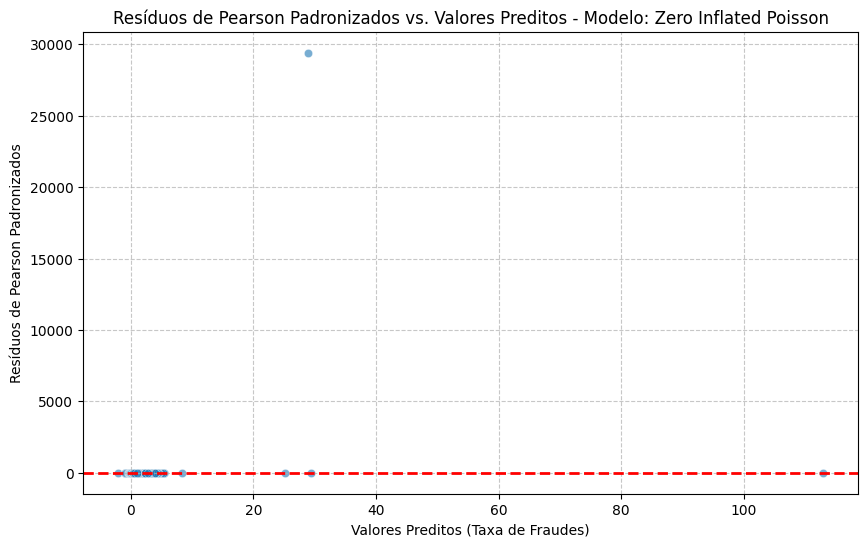

In [57]:
overdisp_plot(modelo_zip_stepwise, 'Zero Inflated Poisson')

In [58]:
X_scaler.columns.to_list()

['mean_amount',
 'mean_current_age',
 'mean_per_capita_income',
 'mean_total_debt',
 'mean_credit_score',
 'mean_num_credit_cards',
 'mean_credit_limit',
 'gender_female',
 'card_brand_amex',
 'card_brand_discover',
 'card_type_debit_prepaid',
 'has_chip_no',
 'category_arts_entertainment_recreation',
 'category_retail_specialty',
 'category_government_utilities',
 'category_food_beverage',
 'category_professional_business_services',
 'category_retail_general_department',
 'category_health_medical',
 'category_sports_recreation',
 'category_retail_clothing_accessories',
 'category_travel_hospitality',
 'category_financial_insurance',
 'category_construction_contractors',
 'category_retail_home_garden',
 'category_manufacturing_industrial',
 'category_personal_services']

mean_current_age , 'mean_credit_limit', 'card_type_debit_prepaid', 'has_chip_no', 'category_financial_insurance', 'category_government_utilities', 'category_sports_recreation','category_construction_contractors', 'category_retail_home_garden', 'category_manufacturing_industrial', 'category_personal_services'


**'category_food_beverage',** -> category_arts_entertainment_recreation'

In [149]:
X1 = X_scaler[
    [
        'mean_amount',
        'mean_current_age',
        'mean_per_capita_income',
        'mean_total_debt',
        'mean_credit_score',
        'card_brand_amex',
        'has_chip_no',
        'category_arts_entertainment_recreation',
        'category_government_utilities',
        'category_food_beverage',
        'category_professional_business_services',
        'category_retail_general_department',
        'category_health_medical',
        'category_sports_recreation',
        'category_travel_hospitality',
        'category_financial_insurance',
        'category_personal_services'
    ]].copy()
X1 = sm.add_constant(X1)

X2 = X_scaler[
    [
        'mean_amount',
        'mean_per_capita_income',
        'mean_total_debt',
        'mean_credit_limit',
        'category_arts_entertainment_recreation',
        'category_retail_specialty',
        'category_government_utilities',
        'category_professional_business_services',
        'category_sports_recreation',
        'category_manufacturing_industrial',
        'category_personal_services'
    ]].copy()
X2 = sm.add_constant(X2)

modelo_zip_stepwise_manual = sm.ZeroInflatedPoisson(y, X1, exog_infl=X2, inflation='logit').fit()
modelo_zip_stepwise_manual.summary()

         Current function value: 1.077961
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                14363
Model:             ZeroInflatedPoisson   Df Residuals:                    14345
Method:                            MLE   Df Model:                           17
Date:                 Wed, 28 May 2025   Pseudo R-squ.:                 0.07541
Time:                         19:30:46   Log-Likelihood:                -15483.
converged:                       False   LL-Null:                       -16746.
Covariance Type:             nonrobust   LLR p-value:                     0.000
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                       1.2187      0.023     52.421      0.000       1.173       1.264
inflate_mean_amount                                 0.3196      0.066      4.868      0.000       0.191       0.448
inflate_mean_per_capita_income                     -0.1957      0.034     -5.692      0.000      -0.263      -0.128
inflate_mean_total_debt                             0.1312      0.028      4.767      0.000       0.077       0.185
inflate_mean_credit_limit                           0.1212      0.031      3.916      0.000       0.061       0.182
inflate_category_arts_entertainment_recreation      0.2252      0.033      6.727      0.000       0.160       0.291
inflate_category_retail_specialty                   0.1045      0.030      3.463      0.001       0.045       0.164
inflate_category_government_utilities               0.1623      0.035      4.678      0.000       0.094       0.230
inflate_category_professional_business_services     0.1454      0.029      5.083      0.000       0.089       0.201
inflate_category_sports_recreation                  0.0845      0.026      3.217      0.001       0.033       0.136
inflate_category_manufacturing_industrial           0.1870      0.043      4.384      0.000       0.103       0.271
inflate_category_personal_services                 -0.1538      0.024     -6.409      0.000      -0.201      -0.107
const                                               1.0095      0.015     66.693      0.000       0.980       1.039
mean_amount                                        -0.1700      0.037     -4.656      0.000      -0.242      -0.098
mean_current_age                                    0.0602      0.016      3.826      0.000       0.029       0.091
mean_per_capita_income                              0.0746      0.017      4.366      0.000       0.041       0.108
mean_total_debt                                    -0.0351      0.017     -2.121      0.034      -0.068      -0.003
mean_credit_score                                   0.0717      0.015      4.752      0.000       0.042       0.101
card_brand_amex                                    -0.0807      0.013     -6.064      0.000      -0.107      -0.055
has_chip_no                                         0.0449      0.013      3.483      0.000       0.020       0.070
category_arts_entertainment_recreation             -0.1562      0.021     -7.310      0.000      -0.198      -0.114
category_government_utilities                      -0.2922      0.022    -13.224      0.000      -0.335      -0.249
category_food_beverage                             -0.3039      0.024    -12.414      0.000      -0.352      -0.256
category_professional_business_services            -0.0866      0.015     -5.805      0.000      -0.116      -0.057
category_retail_general_department                 -0.0754      0.019     -3.959      0.000      -0.

LLH: -15483

Psuedo R2: 0.07541

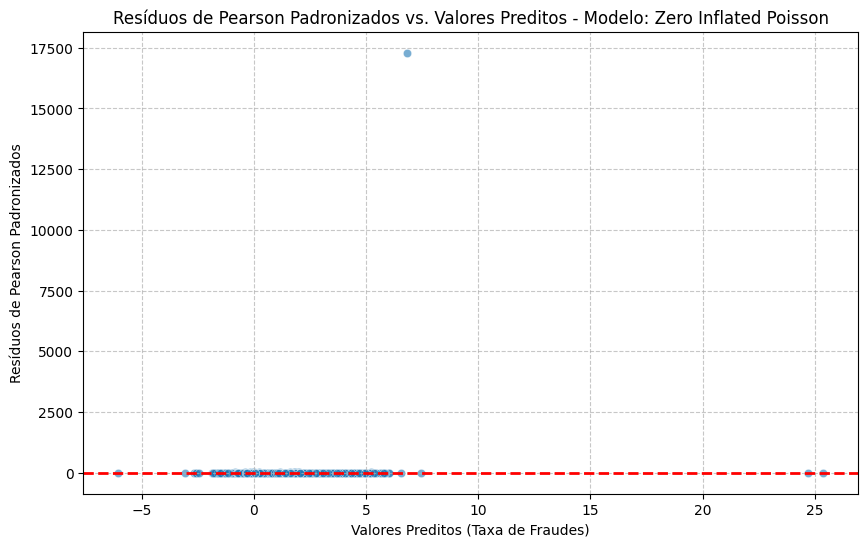

In [150]:
overdisp_plot(modelo_zip_stepwise_manual, 'Zero Inflated Poisson')

In [151]:
lrtest([modelo_zip_stepwise, modelo_zip_stepwise_manual])

Likelihood Ratio Test:
-2.(LL0-LLm): -30.18
p-value: 1.000

==================Result======================== 

H0: Models with log-likelihoods that are not statistically different at 95% confidence level


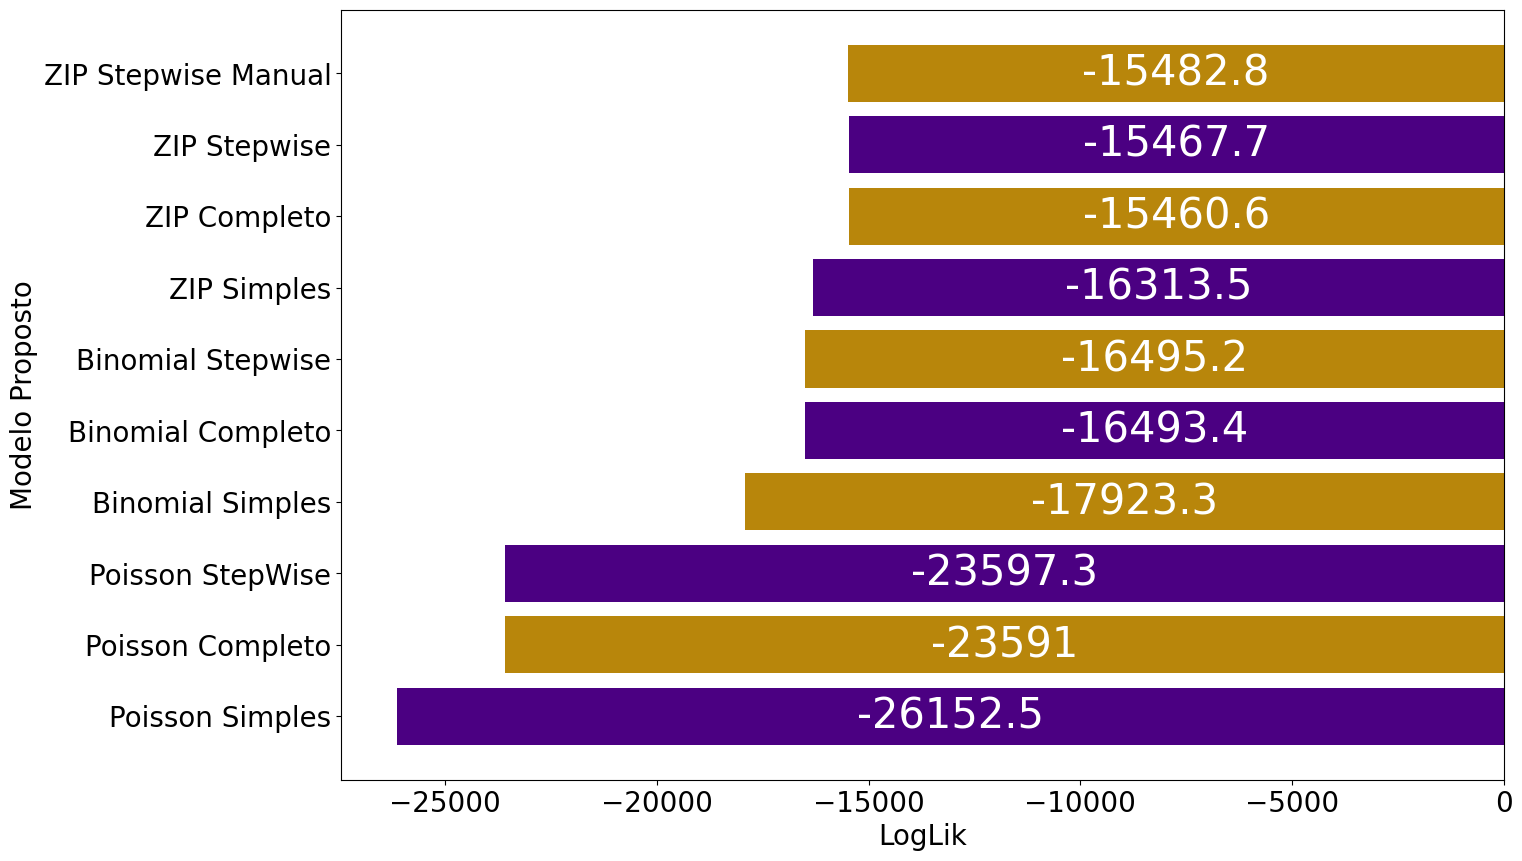

In [152]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo',
        'ZIP Stepwise',
        'ZIP Stepwise Manual'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf,
        modelo_zip_stepwise.llf,
        modelo_zip_stepwise_manual.llf
      ]
})

### ZINB - Zero Inflated Negative Benomial

In [153]:
X1 = X_scaler['mean_amount']
X1 = sm.add_constant(X1)

In [154]:
modelo_zinb_simples = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1, inflation='logit').fit()
modelo_zinb_simples.summary()

         Current function value: 1.035573
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                14363
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    14361
Method:                                      MLE   Df Model:                            1
Date:                           Wed, 28 May 2025   Pseudo R-squ.:                 0.02198
Time:                                   19:31:44   Log-Likelihood:                -14874.
converged:                                 False   LL-Null:                       -15208.
Covariance Type:                       nonrobust   LLR p-value:                1.910e-147
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
inflate_const           0.7475      0.050     14.979      0.000       0.650       0.845
inflate_mean_amount     0.8162      0.058     14.094      0.000       0.703       0.930
const                   0.8913      0.036     24.432      0.000       0.820       0.963
mean_amount            -0.4454      0.049     -9.169      0.000      -0.541      -0.350
alpha                   1.1187      0.087     12.910      0.000       0.949       1.289
=======================================================================================
"""

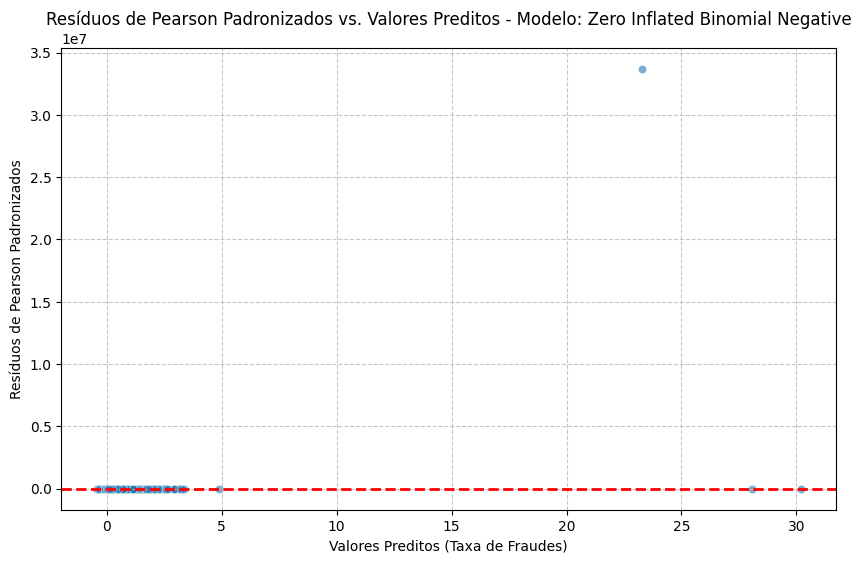

In [155]:
overdisp_plot(modelo_zinb_simples, 'Zero Inflated Binomial Negative')

In [156]:
vuong_test(modelo_binomialneg_simples, modelo_zinb_simples)

         Current function value: nan
         Iterations: 1
         Function evaluations: 19
         Gradient evaluations: 19
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -35.87
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


In [157]:
X1 = X_scaler.copy(deep=True)
X1 = sm.add_constant(X1)

In [158]:
modelo_zinb_complete = sm.ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1, inflation='logit').fit()
modelo_zinb_complete.summary()

         Current function value: 0.998389
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                14363
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    14335
Method:                                      MLE   Df Model:                           27
Date:                           Wed, 28 May 2025   Pseudo R-squ.:                 0.05710
Time:                                   19:32:56   Log-Likelihood:                -14340.
converged:                                 False   LL-Null:                       -15208.
Covariance Type:                       nonrobust   LLR p-value:                     0.000
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                       0.7669      0.046     16.721      0.000       0.677       0.857
inflate_mean_amount                                 0.0736      0.104      0.706      0.480      -0.131       0.278
inflate_mean_current_age                            0.0022      0.044      0.051      0.959      -0.083       0.088
inflate_mean_per_capita_income                     -0.1403      0.050     -2.800      0.005      -0.238      -0.042
inflate_mean_total_debt                             0.0900      0.041      2.218      0.027       0.010       0.170
inflate_mean_credit_score                          -0.0101      0.038     -0.264      0.792      -0.085       0.065
inflate_mean_num_credit_cards                      -0.1057      0.041     -2.594      0.009      -0.186      -0.026
inflate_mean_credit_limit                           0.1294      0.045      2.855      0.004       0.041       0.218
inflate_gender_female                              -0.0109      0.034     -0.317      0.751      -0.078       0.056
inflate_card_brand_amex                            -0.0092      0.033     -0.278      0.781      -0.074       0.056
inflate_card_brand_discover                         0.0328      0.032      1.015      0.310      -0.031       0.096
inflate_card_type_debit_prepaid                     0.0301      0.038      0.791      0.429      -0.044       0.105
inflate_has_chip_no                                 0.0840      0.032      2.622      0.009       0.021       0.147
inflate_category_arts_entertainment_recreation      0.2682      0.045      5.897      0.000       0.179       0.357
inflate_category_retail_specialty                   0.1483      0.040      3.710      0.000       0.070       0.227
inflate_category_government_utilities               0.0742      0.053      1.398      0.162      -0.030       0.178
inflate_category_food_beverage                     -0.1719      0.065     -2.659      0.008      -0.299      -0.045
inflate_category_professional_business_services     0.1328      0.037      3.627      0.000       0.061       0.205
inflate_category_retail_general_department          0.0252      0.046      0.543      0.587      -0.066       0.116
inflate_category_health_medical                    -0.0154      0.037     -0.417      0.677      -0.088       0.057
inflate_category_sports_recreation                  0.0853      0.034      2.522      0.012       0.019       0.152
inflate_category_retail_clothing_accessories       -0.0078      0.030     -0.265      0.791      -0.066       0.050
inflate_category_travel_hospitality                 0.0783      0.075      1.045      0.296      -0.069       0.225
inflate_category_financial_insurance               -0.0329      0.035     -0.936      0.349      -0.102       0.036
inflate_ca

In [159]:
X_scaler.columns.to_list()

['mean_amount',
 'mean_current_age',
 'mean_per_capita_income',
 'mean_total_debt',
 'mean_credit_score',
 'mean_num_credit_cards',
 'mean_credit_limit',
 'gender_female',
 'card_brand_amex',
 'card_brand_discover',
 'card_type_debit_prepaid',
 'has_chip_no',
 'category_arts_entertainment_recreation',
 'category_retail_specialty',
 'category_government_utilities',
 'category_food_beverage',
 'category_professional_business_services',
 'category_retail_general_department',
 'category_health_medical',
 'category_sports_recreation',
 'category_retail_clothing_accessories',
 'category_travel_hospitality',
 'category_financial_insurance',
 'category_construction_contractors',
 'category_retail_home_garden',
 'category_manufacturing_industrial',
 'category_personal_services']

In [165]:
df_features_zip_complete = modelo_zinb_complete.pvalues.where(lambda x: x < 0.05).dropna().reset_index().rename(columns={'index':'Features', 0:'P-Value'})
feature_exog = list(filter(lambda x: x not in ['const', 'alpha'], df_features_zip_complete.query('~Features.str.contains("inflate_")')['Features'].apply(lambda x: str(x).replace('inflate_','')).to_list()))
print('Exogenas')
print(feature_exog)
feature_exog_inflate = list(filter(lambda x: x not in ['const', 'alpha'], df_features_zip_complete.query('Features.str.contains("inflate_")')['Features'].apply(lambda x: str(x).replace('inflate_','')).to_list()))
print('Exogenas Inflado')
print(feature_exog_inflate)

Exogenas
['mean_amount', 'mean_current_age', 'mean_per_capita_income', 'mean_credit_score', 'card_brand_amex', 'has_chip_no', 'category_arts_entertainment_recreation', 'category_government_utilities', 'category_food_beverage', 'category_professional_business_services', 'category_retail_general_department', 'category_health_medical', 'category_travel_hospitality', 'category_personal_services']
Exogenas Inflado
['mean_per_capita_income', 'mean_total_debt', 'mean_num_credit_cards', 'mean_credit_limit', 'has_chip_no', 'category_arts_entertainment_recreation', 'category_retail_specialty', 'category_food_beverage', 'category_professional_business_services', 'category_sports_recreation', 'category_manufacturing_industrial', 'category_personal_services']


In [166]:
X1 = X_scaler[feature_exog].copy()
X1 = sm.add_constant(X1)

X2 = X_scaler[feature_exog_inflate].copy()
X2 = sm.add_constant(X2)

modelo_zinb_stepwise = sm.ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X2, inflation='logit').fit()
modelo_zinb_stepwise.summary()

         Current function value: 0.999362
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                14363
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    14348
Method:                                      MLE   Df Model:                           14
Date:                           Wed, 28 May 2025   Pseudo R-squ.:                 0.05618
Time:                                   19:37:15   Log-Likelihood:                -14354.
converged:                                 False   LL-Null:                       -15208.
Covariance Type:                       nonrobust   LLR p-value:                     0.000
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                       0.7412      0.042     17.454      0.000       0.658       0.824
inflate_mean_per_capita_income                     -0.2100      0.044     -4.824      0.000      -0.295      -0.125
inflate_mean_total_debt                             0.1292      0.033      3.916      0.000       0.065       0.194
inflate_mean_num_credit_cards                      -0.0700      0.031     -2.246      0.025      -0.131      -0.009
inflate_mean_credit_limit                           0.1501      0.036      4.218      0.000       0.080       0.220
inflate_has_chip_no                                 0.0776      0.032      2.411      0.016       0.015       0.141
inflate_category_arts_entertainment_recreation      0.2407      0.041      5.931      0.000       0.161       0.320
inflate_category_retail_specialty                   0.1226      0.033      3.751      0.000       0.059       0.187
inflate_category_food_beverage                     -0.2300      0.035     -6.569      0.000      -0.299      -0.161
inflate_category_professional_business_services     0.1552      0.036      4.337      0.000       0.085       0.225
inflate_category_sports_recreation                  0.1322      0.030      4.477      0.000       0.074       0.190
inflate_category_manufacturing_industrial           0.2521      0.045      5.664      0.000       0.165       0.339
inflate_category_personal_services                 -0.1810      0.033     -5.530      0.000      -0.245      -0.117
const                                               0.6465      0.033     19.500      0.000       0.582       0.711
mean_amount                                        -0.4298      0.065     -6.587      0.000      -0.558      -0.302
mean_current_age                                    0.0745      0.026      2.821      0.005       0.023       0.126
mean_per_capita_income                              0.0882      0.032      2.727      0.006       0.025       0.152
mean_credit_score                                   0.0734      0.028      2.641      0.008       0.019       0.128
card_brand_amex                                    -0.0876      0.024     -3.605      0.000      -0.135      -0.040
has_chip_no                                         0.0713      0.027      2.595      0.009       0.017       0.125
category_arts_entertainment_recreation             -0.1536      0.034     -4.525      0.000      -0.220      -0.087
category_government_utilities                      -0.4087      0.037    -10.988      0.000      -0.482      -0.336
category_food_beverage                             -0.4960      0.046    -10.840      0.000      -0.586      -0.406
category_professional_business_services            -0.1076      0.031     -3.510      0.000      -0.168      -0.048
category_r

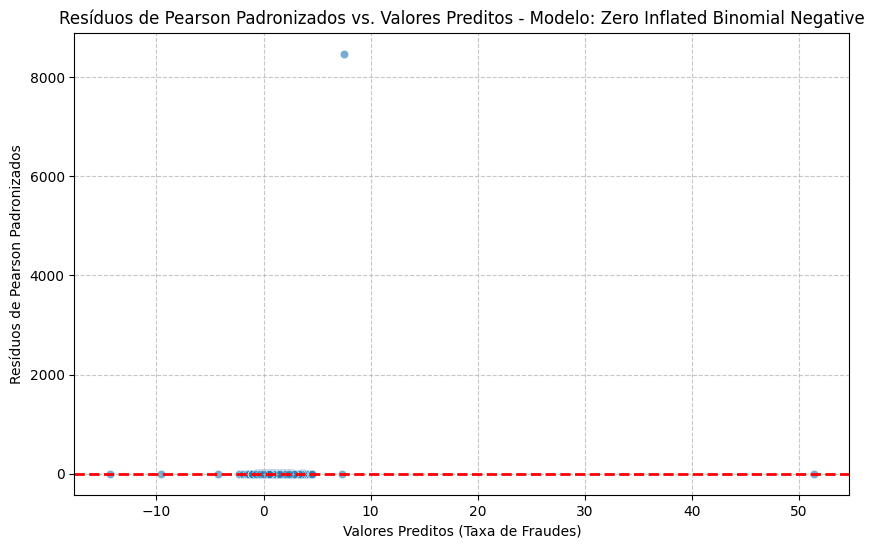

In [167]:
overdisp_plot(modelo_zinb_stepwise, 'Zero Inflated Binomial Negative')

In [176]:
X_scaler.columns.to_list()

['mean_amount',
 'mean_current_age',
 'mean_per_capita_income',
 'mean_total_debt',
 'mean_credit_score',
 'mean_num_credit_cards',
 'mean_credit_limit',
 'gender_female',
 'card_brand_amex',
 'card_brand_discover',
 'card_type_debit_prepaid',
 'has_chip_no',
 'category_arts_entertainment_recreation',
 'category_retail_specialty',
 'category_government_utilities',
 'category_food_beverage',
 'category_professional_business_services',
 'category_retail_general_department',
 'category_health_medical',
 'category_sports_recreation',
 'category_retail_clothing_accessories',
 'category_travel_hospitality',
 'category_financial_insurance',
 'category_construction_contractors',
 'category_retail_home_garden',
 'category_manufacturing_industrial',
 'category_personal_services']

In [290]:
X1 = X_scaler[
    [
        'mean_amount',
        'mean_current_age',
        'mean_per_capita_income',
        'mean_total_debt',
        'card_brand_amex',
        'category_food_beverage',
        'category_professional_business_services',
        'category_retail_general_department',
        'category_sports_recreation',
        'category_travel_hospitality',
        'category_manufacturing_industrial',
        'category_personal_services'
    ]].copy()
X1 = sm.add_constant(X1)

X2 = X_scaler[
    [
        'mean_amount',
        'mean_current_age',
        'mean_per_capita_income',
        'mean_credit_limit',
        'category_arts_entertainment_recreation',
        'category_retail_specialty',
        'category_government_utilities',
        'category_professional_business_services',
        'category_sports_recreation',
        'category_retail_home_garden',

    ]].copy()
X2 = sm.add_constant(X2)

modelo_zinb_stepwise_manual = sm.ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X2, inflation='logit').fit()
modelo_zinb_stepwise_manual.summary()

         Current function value: 1.003926
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                14363
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    14350
Method:                                      MLE   Df Model:                           12
Date:                           Wed, 28 May 2025   Pseudo R-squ.:                 0.05187
Time:                                   20:44:09   Log-Likelihood:                -14419.
converged:                                 False   LL-Null:                       -15208.
Covariance Type:                       nonrobust   LLR p-value:                     0.000
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                       0.7538      0.044     17.314      0.000       0.668       0.839
inflate_mean_amount                                 0.1626      0.076      2.154      0.031       0.015       0.311
inflate_mean_current_age                           -0.0807      0.032     -2.491      0.013      -0.144      -0.017
inflate_mean_per_capita_income                     -0.1326      0.043     -3.063      0.002      -0.217      -0.048
inflate_mean_credit_limit                           0.1584      0.037      4.332      0.000       0.087       0.230
inflate_category_arts_entertainment_recreation      0.3046      0.037      8.293      0.000       0.233       0.377
inflate_category_retail_specialty                   0.1739      0.032      5.375      0.000       0.111       0.237
inflate_category_government_utilities               0.3158      0.039      8.027      0.000       0.239       0.393
inflate_category_professional_business_services     0.1372      0.036      3.800      0.000       0.066       0.208
inflate_category_sports_recreation                  0.0996      0.033      3.044      0.002       0.035       0.164
inflate_category_retail_home_garden                 0.0749      0.031      2.401      0.016       0.014       0.136
const                                               0.6731      0.034     19.624      0.000       0.606       0.740
mean_amount                                        -0.4810      0.069     -6.953      0.000      -0.617      -0.345
mean_current_age                                    0.0739      0.030      2.461      0.014       0.015       0.133
mean_per_capita_income                              0.1673      0.035      4.793      0.000       0.099       0.236
mean_total_debt                                    -0.0879      0.029     -3.070      0.002      -0.144      -0.032
card_brand_amex                                    -0.0820      0.025     -3.316      0.001      -0.131      -0.034
category_food_beverage                             -0.3207      0.038     -8.360      0.000      -0.396      -0.246
category_professional_business_services            -0.1331      0.031     -4.326      0.000      -0.193      -0.073
category_retail_general_department                 -0.1132      0.035     -3.215      0.001      -0.182      -0.044
category_sports_recreation                         -0.0575      0.027     -2.164      0.030      -0.110      -0.005
category_travel_hospitality                        -0.2365      0.055     -4.263      0.000      -0.345      -0.128
category_manufacturing_industrial                  -0.1190      0.038     -3.097      0.002      -0.194      -0.044
category_personal_services                          0.1309      0.025      5.267      0.000       0.082       0.180
alpha     

LLH: -14419

Pseudo R: 0.05187

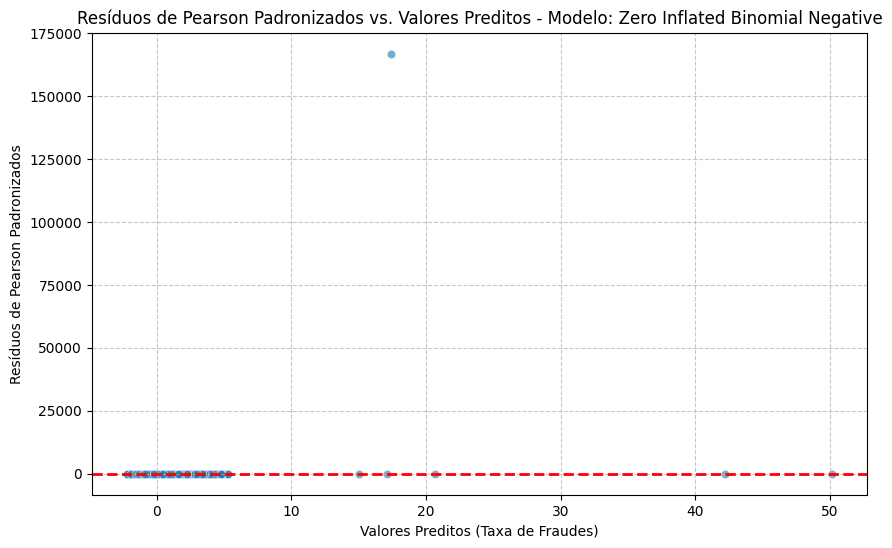

In [291]:
overdisp_plot(modelo_zinb_stepwise_manual, 'Zero Inflated Binomial Negative')

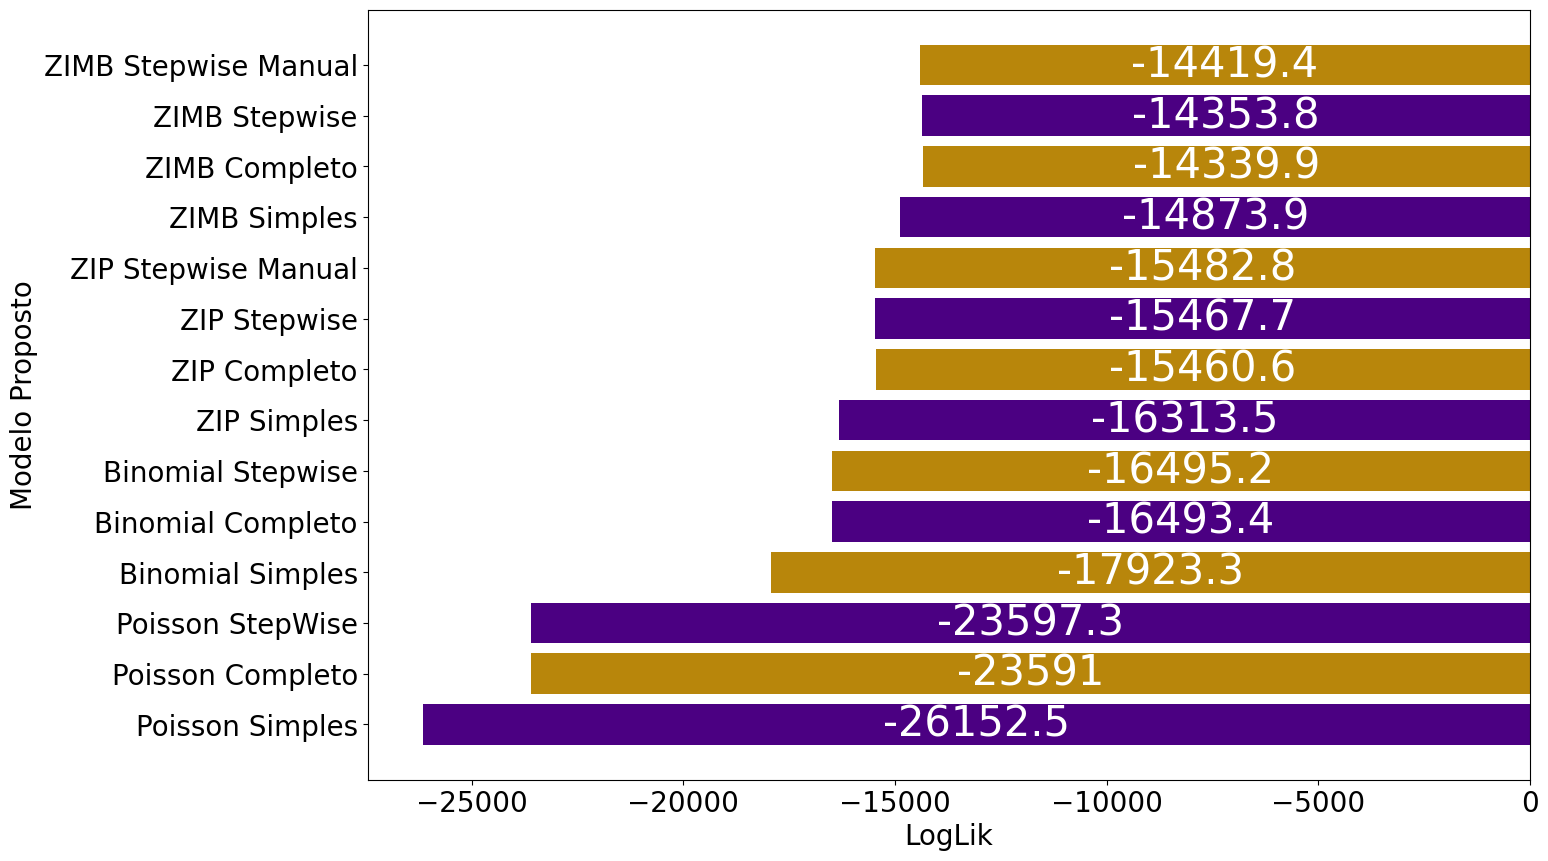

In [292]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo',
        'ZIP Stepwise',
        'ZIP Stepwise Manual',
        'ZIMB Simples',
        'ZIMB Completo',
        'ZIMB Stepwise',
        'ZIMB Stepwise Manual',
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf,
        modelo_zip_stepwise.llf,
        modelo_zip_stepwise_manual.llf,
        modelo_zinb_simples.llf,
        modelo_zinb_complete.llf,
        modelo_zinb_stepwise.llf,
        modelo_zinb_stepwise_manual.llf
      ]
})

In [294]:
titles = [
  'Poisson Simples',
  'Poisson Completo',
  'Poisson StepWise',
  'Binomial Simples',
  'Binomial Completo',
  'Binomial Stepwise',
  'ZIP Simples',
  'ZIP Completo',
  'ZIP Stepwise',
  'ZIP Stepwise Manual',
  'ZIMB Simples',
  'ZIMB Completo',
  'ZIMB Stepwise',
  'ZIMB Stepwise Manual',
]
models = [
    modelo_poison_simple,
    modelo_poison_complete,
    modelo_poisson_stepswise,
    modelo_binomialneg_simples,
    modelo_binomialneg_completo,
    modelo_binomialneg_stepwise,
    modelo_zip_simples,
    modelo_zip_complete,
    modelo_zip_stepwise,
    modelo_zip_stepwise_manual,
    modelo_zinb_simples,
    modelo_zinb_complete,
    modelo_zinb_stepwise,
    modelo_zinb_stepwise_manual
]

In [297]:
metrics = []
for title, model in zip(titles, models):
  metrics.append(dict(title=title, LLF=model.llf, BIC=model.bic, AIC=model.aic))

In [299]:
df_metrics = pd.DataFrame(metrics)
df_metrics.sort_values(by='AIC')

,title,LLF,BIC,AIC
12,ZIMB Stepwise,-14353.834412,28985.268735,28765.668823
11,ZIMB Completo,-14339.862481,29225.352374,28793.724962
13,ZIMB Stepwise Manual,-14419.391833,29078.093935,28888.783667
10,ZIMB Simples,-14873.930219,29795.722491,29757.860437
8,ZIP Stepwise,-15467.666505,31270.367386,31005.333010
9,ZIP Stepwise Manual,-15482.757704,31252.687730,31025.515408
7,ZIP Completo,-15460.599687,31457.254375,31033.199374
6,ZIP Simples,-16313.532174,32665.353990,32635.064347
5,Binomial Stepwise,-16495.150946,-119124.613524,33036.301891
4,Binomial Completo,-16493.415092,-119041.935414,33050.830184


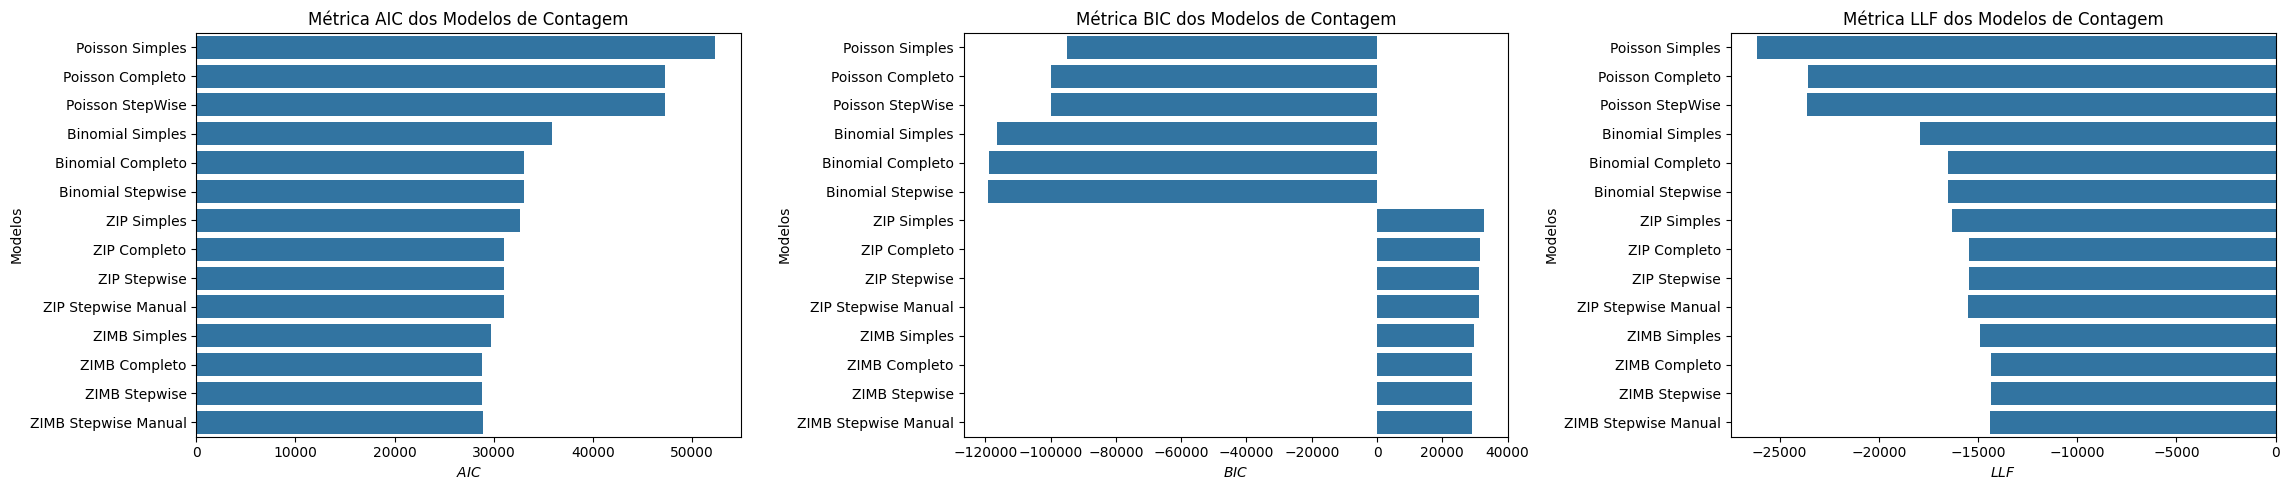

In [308]:
plt.figure(figsize=(23,5))

plt.subplot(1,3,1)
plt.title('Métrica AIC dos Modelos de Contagem')
sns.barplot(data=df_metrics, y='title', x='AIC')
plt.xlabel('$AIC$')
plt.ylabel('Modelos')

plt.subplot(1,3,2)
plt.title('Métrica BIC dos Modelos de Contagem')
sns.barplot(data=df_metrics, y='title', x='BIC')
plt.xlabel('$BIC$')
plt.ylabel('Modelos')

plt.subplot(1,3,3)
plt.title('Métrica LLF dos Modelos de Contagem')
sns.barplot(data=df_metrics, y='title', x='LLF')
plt.xlabel('$LLF$')
plt.ylabel('Modelos')

plt.tight_layout()
plt.show()